In [51]:
import pandas as pd
import xgboost as xgb

In [2]:
%matplotlib inline

In [3]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

In [4]:
combined_set = pd.concat([train_data, test_data])
combined_set['combined_var'] = (combined_set.hair_length * .40) + (combined_set.has_soul * .40)

# Replace categorical variables with numbers
def label_encoding(df, col):
    label_map = { key: float(n) for n, key in enumerate(df[col].unique()) }
    label_reverse_map = { label_map[key]: key for key in label_map }
    df[col] = df[col].apply(lambda x: label_map[x])
    return df, label_map, label_reverse_map

combined_set, _, _ = label_encoding(combined_set, 'color')

train_set = combined_set[:len(train_data.index)]
test_set = combined_set[len(train_data.index):]

In [5]:
train_set.head()

,bone_length,color,hair_length,has_soul,id,rotting_flesh,type,combined_var
0,0.354512,0.0,0.465761,0.781142,0,0.350839,Ghoul,0.498761
1,0.575560,1.0,0.531401,0.439899,1,0.425868,Goblin,0.388520
2,0.467875,2.0,0.811616,0.791225,2,0.354330,Ghoul,0.641136
3,0.776652,2.0,0.636766,0.884464,4,0.508723,Ghoul,0.608492
4,0.566117,1.0,0.418594,0.636438,5,0.875862,Ghost,0.422013


In [6]:
monster_types = pd.get_dummies(train_set.type)

In [7]:
train_cols = ['combined_var', 'rotting_flesh', 'bone_length', 'has_soul', 'hair_length']

In [57]:
params = {'max_depth':5, 'eta':0.001, 'silent':1, 'objective':'binary:logistic'}
# params['num_class'] = 3
params['seed'] = 7
params['subsample'] = 0.7
params['gamma'] = 0
params['min_child_weight'] = 0.1
params['tree_method'] = 'exact'
params['sketch_eps'] = 0.4
params['max_delta_step'] = 1

models = {}
predictions = {}

for monster_type in monster_types.columns:
    train = train_set[train_cols]
    if monster_type == 'Ghoul':
        train.combined_var = (train.rotting_flesh + 
                              train.bone_length +
                              train.has_soul +
                              train.hair_length)
    dtrain = xgb.DMatrix(train[train_cols], feature_names=train_cols, label=monster_types[monster_type])
    dtest = xgb.DMatrix(test_set[train_cols], feature_names=train_cols)
    print(monster_type)
    print(xgb.cv(params, dtrain, nfold=10, num_boost_round=20))
    model = xgb.train(params, dtrain, num_boost_round=80)
    preds = model.predict(dtest)
    models[monster_type] = model
    predictions[monster_type] = preds

Ghost


/home/jayant/anaconda3/lib/python3.5/site-packages/xgboost/training.py:272: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  idset = [randidx[(i * kstep): min(len(randidx), (i + 1) * kstep)] for i in range(nfold)]


    test-error-mean  test-error-std  train-error-mean  train-error-std
0          0.126814        0.038578          0.066489         0.011902
1          0.118563        0.038467          0.061992         0.006122
2          0.118705        0.044102          0.053605         0.007246
3          0.116003        0.043840          0.057201         0.006741
4          0.107895        0.032165          0.054206         0.007961
5          0.113300        0.039900          0.054505         0.005133
6          0.118705        0.030370          0.049413         0.009191
7          0.121408        0.038925          0.049711         0.008366
8          0.118705        0.034850          0.050609         0.009955
9          0.116003        0.038518          0.050911         0.009459
10         0.118705        0.034850          0.049713         0.009188
11         0.118705        0.034850          0.048817         0.007812
12         0.116003        0.029988          0.050611         0.006467
13    

/home/jayant/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Ghoul
    test-error-mean  test-error-std  train-error-mean  train-error-std
0          0.183428        0.052747          0.107514         0.014920
1          0.188620        0.056446          0.108119         0.012688
2          0.175178        0.036608          0.097628         0.015365
3          0.178023        0.044275          0.099127         0.015209
4          0.169914        0.060710          0.100931         0.012082
5          0.169843        0.040285          0.097632         0.012564
6          0.177951        0.045716          0.097636         0.010915
7          0.172546        0.038743          0.095838         0.012352
8          0.167141        0.039800          0.096437         0.011517
9          0.167141        0.043315          0.097336         0.014203
10         0.167141        0.039800          0.098534         0.011571
11         0.161735        0.045243          0.096739         0.011397
12         0.161735        0.043599          0.096138         0.010766


In [9]:
final_predictions = pd.np.argmax(pd.DataFrame(predictions).values, axis=1)

In [10]:
label_map = {index: col for index, col in enumerate(pd.DataFrame(predictions).columns) }

In [11]:
sub = pd.DataFrame({'id': test_set.id, 'type': final_predictions})
sub['type'] = sub.type.apply(lambda x: label_map[x])

In [12]:
sub.to_csv('xbg_ens_solution1.csv', index=False)

In [13]:
models.keys()

dict_keys(['Ghoul', 'Ghost', 'Goblin'])

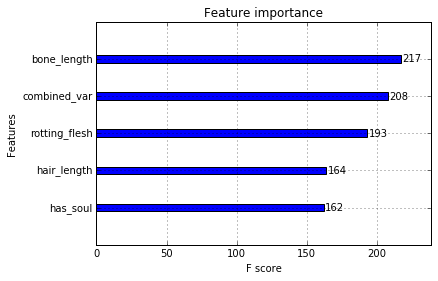

In [14]:
xgb.plot_importance(models['Ghost'])

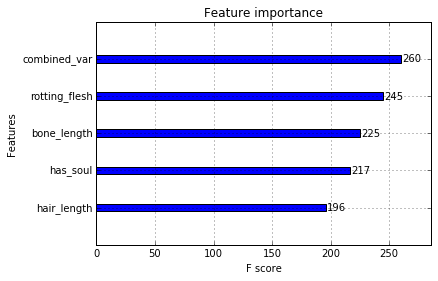

In [15]:
xgb.plot_importance(models['Goblin'])

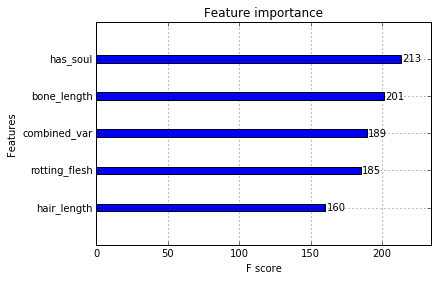

In [16]:
xgb.plot_importance(models['Ghoul'])

In [17]:
goblin_train_set = pd.concat([train_set[train_cols], monster_types['Goblin']], axis=1)

In [91]:
goblin_train_set.combined_var = (goblin_train_set.has_soul *
                                 goblin_train_set.hair_length)
goblin_train_set['combined_var2'] = (goblin_train_set.has_soul *
                                     goblin_train_set.hair_length * goblin_train_set.rotting_flesh)

In [92]:
# add color dummies
colors = pd.get_dummies(train_data.color)
goblin_with_color = pd.concat([goblin_train_set, colors], axis=1)

In [93]:
test_colors = pd.get_dummies(test_data.color)
test_gwc = pd.concat([test_set, test_colors], axis=1)

In [94]:
test_gwc['combined_var2'] = (test_gwc.has_soul *
                             test_gwc.hair_length * test_gwc.rotting_flesh)

In [121]:
goblin_train_cols = ['combined_var', 'rotting_flesh', 'has_soul'] 

In [122]:
dtrain = xgb.DMatrix(goblin_with_color[goblin_train_cols], feature_names=goblin_train_cols, label=monster_types['Goblin'])
dtest = xgb.DMatrix(test_gwc[goblin_train_cols], feature_names=goblin_train_cols)

In [123]:
xgb.cv(params, dtrain, nfold=10, num_boost_round=30)

/home/jayant/anaconda3/lib/python3.5/site-packages/xgboost/training.py:272: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  idset = [randidx[(i * kstep): min(len(randidx), (i + 1) * kstep)] for i in range(nfold)]


,test-error-mean,test-error-std,train-error-mean,train-error-std
0,0.331721,0.063598,0.196454,0.027115
1,0.320697,0.051460,0.185075,0.016618
2,0.296372,0.036995,0.162919,0.011550
3,0.293670,0.048020,0.162020,0.009428
4,0.274822,0.050239,0.159924,0.009414
5,0.293741,0.042127,0.151836,0.012501
6,0.277454,0.067491,0.152731,0.016920
7,0.269417,0.055931,0.154230,0.014300
8,0.263940,0.055069,0.153930,0.017148
9,0.269345,0.052722,0.152435,0.013625


In [124]:
goblin_model = xgb.train(params, dtrain, num_boost_round=20)

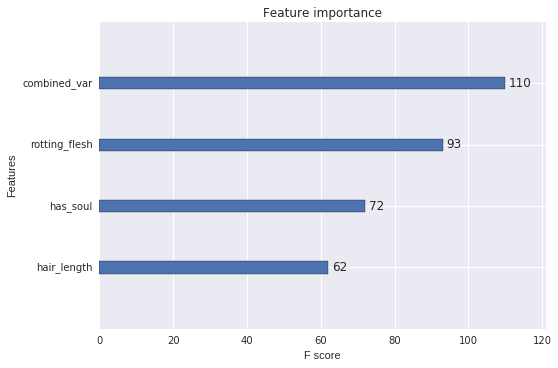

In [125]:
xgb.plot_importance(goblin_model)

In [66]:
import seaborn as sns

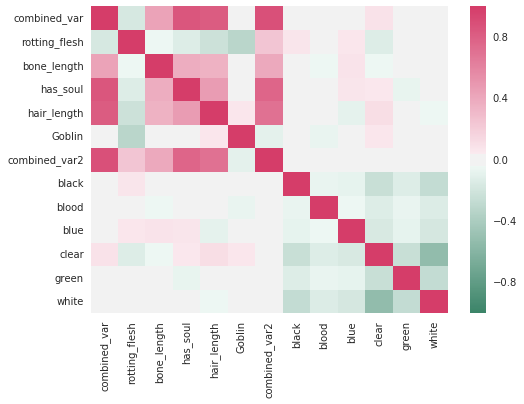

In [67]:
cmap = sns.diverging_palette(154, 0, as_cmap=True)
sns.heatmap(goblin_with_color.corr(),
            cmap=cmap)

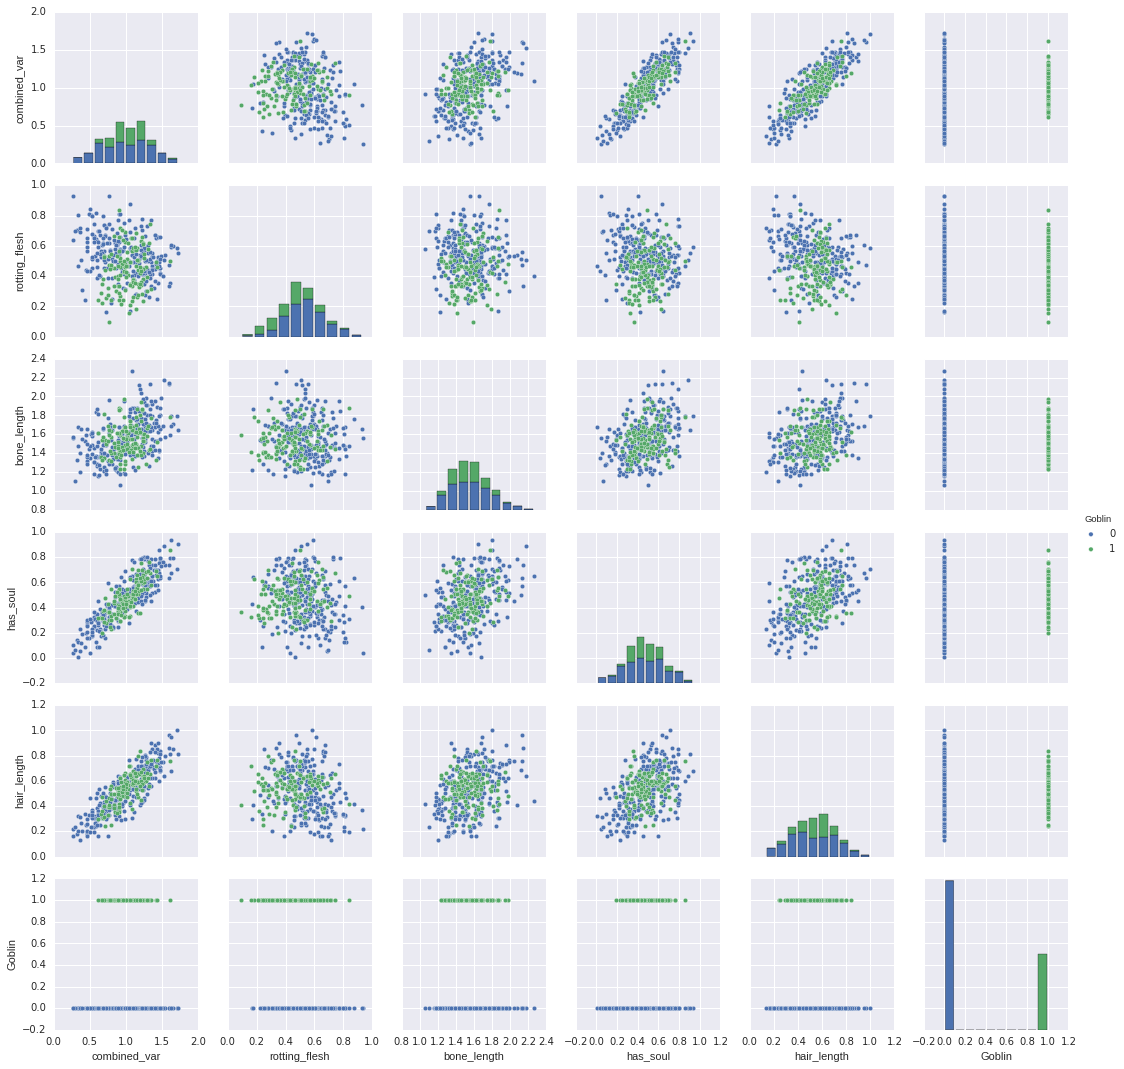

In [255]:
sns.pairplot(goblin_with_color[train_cols + ['Goblin']],  hue='Goblin')

In [256]:
# from sklearn.neural_network import MLPClassifier

In [303]:
# clf = MLPClassifier(hidden_layer_sizes=(50), random_state=7,
#                     activation='logistic',
#                     solver='lbfgs',
#                     verbose=1, max_iter=300, 
#                     tol = 0.00001, early_stopping=False)
# clf.fit(goblin_with_color[goblin_train_cols], monster_types['Goblin'])

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=50, learning_rate='constant',
       learning_rate_init=0.001, max_iter=300, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=7, shuffle=True,
       solver='lbfgs', tol=1e-05, validation_fraction=0.1, verbose=1,
       warm_start=False)

In [309]:
# goblin_preds = clf.predict(test_gwc[goblin_train_cols])

In [310]:
# predictions['Goblin'] = goblin_preds

In [312]:
# final_predictions = pd.np.argmax(pd.DataFrame(predictions).values, axis=1)
# sub = pd.DataFrame({'id': test_set.id, 'type': final_predictions})
# sub['type'] = sub.type.apply(lambda x: label_map[x])
# sub.to_csv('nn_mix_model.csv', index=False)